In [150]:
import os
import math
import cvzone
import cv2 as cv
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from typing import Literal, Union, Any, List, Tuple, Dict

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as F
from torch import Tensor
from torchvision.ops import masks_to_boxes
from torchvision.transforms.functional import InterpolationMode

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

В polygons первое число - номер класса. Далее последовательность чисел - координаты точек (x, y, x, y, x, y, x ...). Спарсим.

In [40]:
def parse_polygons(loc: str) -> List[np.ndarray]:
    polygons = []
    with open(loc, 'r') as f:
        for line in f:
            line = line.strip().split()
            cls = int(line[0])
            coord = list(map(float, line[1:]))
            coord = np.array(coord, dtype="float64").reshape(-1, 2)
            polygons.append((cls, coord))
    return polygons


class CardAffine(T.RandomAffine):

    def __init__(self, degrees, translate=None, scale=None, shear=None, 
                 interpolation=InterpolationMode.NEAREST, fill=0, mask_fill=255, mask_mode: Literal["RGBA", "L"] = "L"):
        super().__init__(degrees, translate, scale, shear, interpolation, fill)
        self.mask_fill = mask_fill
        self.mask_mode = mask_mode

    def forward(self, img: Image.Image, polygons: List[np.ndarray]) -> Tuple[Image.Image, List[np.ndarray]]:

        if img.mode != "RGBA":
            img = img.convert("RGBA")

        fill = self.fill
        channels, height, width = F.get_dimensions(img)
        if isinstance(img, Tensor):
            if isinstance(fill, (int, float)):
                fill = [float(fill)]*channels
            else:
                fill = [float(f) for f in fill]

        img_size = [width, height]  # flip for keeping BC on get_params call

        ret = self.get_params(self.degrees, self.translate, self.scale, self.shear, img_size)
        angle, translations, scale, shear = ret

        # получаем матрицу трансформаций
        matrix = F._get_inverse_affine_matrix(center=[width*0.5, height*0.5], angle=angle, translate=translations, 
                                              scale=scale, shear=shear, inverted=False)
        matrix = np.array(matrix)
        matrix = matrix.reshape(2, 3)
        m_transf, m_transl = matrix[:, :2], matrix[:, 2:]

        # обозначим координаты углов изображения: левый нижний и левый верхний, правый нижний и правый верхний
        # первый столбец - координата X, второй - координата Y
        img_corns = np.array([
            [0.0, 0.0     ],  # левый нижний
            [0.0, height  ],  # левый верхний
            [width, 0.0   ],  # правый нижний
            [width, height],  # правый верхний
        ])
        # применим матрицу преобразований к координатам углов изображения
        img_corns_transf = (m_transf @ img_corns.T) + m_transl
        img_corns_transf = img_corns_transf.T
        bottom = img_corns_transf[:, 1].min()
        left = img_corns_transf[:, 0].min()

        # теперь нам нужно изменить изображение так, чтобы после трансформации углы карты
        # не вылезали за пределы изображения и карта не была обрезана
        ext_width_margin  = min(0, left)
        ext_width_margin  = abs(ext_width_margin)
        ext_width_margin  = math.ceil(ext_width_margin)
        ext_height_margin = min(0, bottom)
        ext_height_margin = abs(ext_height_margin)
        ext_height_margin = math.ceil(ext_height_margin)
        img = F.pad(img, padding=(ext_width_margin, ext_height_margin), fill=fill)

        # применяем афинные преобразования к изображению
        img_aff = F.affine(img, *ret, interpolation=self.interpolation, fill=fill, center=[img.width*0.5, img.height*0.5])

        # обрезаем изображение
        crop_width_margin  = max(0, left)
        crop_width_margin  = math.floor(crop_width_margin)
        crop_height_margin = max(0, bottom)
        crop_height_margin = math.floor(crop_height_margin)
        left, bottom = 0 + crop_width_margin, 0 + crop_height_margin
        right, top = img.width - crop_width_margin, img.height - crop_height_margin
        img_aff = img_aff.crop((left, bottom, right, top))

        # модифицируем разметку карт
        masks = []
        for cls, poly in polygons:
            poly = poly*np.array([width, height])
            poly = (m_transf @ poly.T) + \
                (m_transl + np.array([[ext_width_margin], [ext_height_margin]]) - np.array([[crop_width_margin], [crop_height_margin]]))
            poly = poly.T
            poly = poly.round()
            poly = poly.astype("int")
            poly = poly.flatten()
            poly = poly.tolist()

            mask = Image.new(mode=self.mask_mode, size=img_aff.size, color=0)
            ImageDraw.Draw(mask).polygon(poly, outline=self.mask_fill, fill=self.mask_fill)
            masks.append((cls, mask))

        return img_aff, masks
    

def mask2bbox(mask: Union[Image.Image, np.ndarray]) -> Tuple[int, int, int, int]:
    if not mask is np.ndarray:
        mask = np.array(mask)

    segmentation = np.where(mask > 0.0)

    # Bounding Box
    if len(segmentation) != 0 and len(segmentation[1]) != 0 and len(segmentation[0]) != 0:
        left   = int(np.min(segmentation[1]))
        right  = int(np.max(segmentation[1]))
        bottom = int(np.min(segmentation[0]))
        top    = int(np.max(segmentation[0]))

        return left, right, bottom, top
    return None


CLASSNAMES = [
    "10C", "10D", "10H", "10S", 
    "2C", "2D", "2H", "2S", 
    "3C", "3D", "3H", "3S", 
    "4C", "4D", "4H", "4S", 
    "5C", "5D", "5H", "5S", 
    "6C", "6D", "6H", "6S", 
    "7C", "7D", "7H", "7S", 
    "8C", "8D", "8H", "8S", 
    "9C", "9D", "9H", "9S", 
    "AC", "AD", "AH", "AS", 
    "JC", "JD", "JH", "JS", 
    "KC", "KD", "KH", "KS", 
    "QC", "QD", "QH", "QS"
    ]

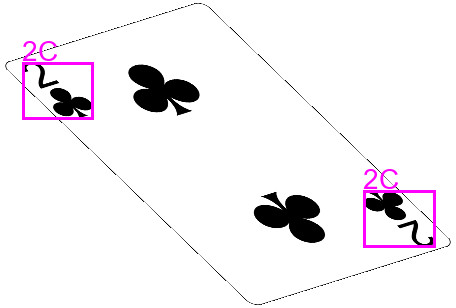

In [139]:
# загружаем данные
img_loc = "./YOLO_custom_dataset/images/68e318d6-2_of_clubs.png"
polygons_loc = "./YOLO_custom_dataset/labels/68e318d6-2_of_clubs.txt"
img = Image.open(img_loc)
polygons = parse_polygons(loc=polygons_loc)

# определяем диапазо афинных преобразований
random_affine_values = dict(
    degrees=      [-180.0, 180.0],
    translate=    [0.0, 0.0],
    scale=        [0.3, 1.0],
    shear=        [-45.0, 45.0],
    interpolation=F.InterpolationMode.BILINEAR,
    fill=         (0, 0, 0, 0)
)
ra = CardAffine(**random_affine_values, mask_fill=255, mask_mode="L")
card, masks = ra(img, polygons)

for cls_idx, mask in masks:
    cls_name = CLASSNAMES[cls_idx]
    left, right, bottom, top = mask2bbox(mask=mask)

    bbox = [(left, bottom), (right, top)]
    draw = ImageDraw.Draw(card, mode="RGBA")
    draw.rectangle(bbox, outline=(255, 0, 255, 255), width=3)

    font = ImageFont.truetype("arial.ttf", 28, encoding="unic")
    draw.text((left, bottom - 1), cls_name, font=font, fill=(255, 0, 255, 255), anchor="lb")
card

Всего изображений карт: 2
Положение центра карты: 772.7288038264269, 632.9885940750181
Размер сгенерированного изображения карты: 174, 172
Положение центра карты: 1146.0704371952547, 170.55724610570223
Размер сгенерированного изображения карты: 442, 288
Положение центра карты: 637.9368394612288, 53.03742488209828
Размер сгенерированного изображения карты: 486, 196
Положение центра карты: 374.3105897285891, 341.810811820923
Размер сгенерированного изображения карты: 320, 202
Положение центра карты: 1007.8519794392322, 147.20178255641903
Размер сгенерированного изображения карты: 484, 168
Положение центра карты: 1244.5782394111932, 396.1629683178258
Размер сгенерированного изображения карты: 90, 170
Положение центра карты: 875.9900291737925, 155.00974718367763
Размер сгенерированного изображения карты: 420, 404
Положение центра карты: 99.10825924824138, 396.75500713874555
Размер сгенерированного изображения карты: 84, 110
Положение центра карты: 362.4701684300254, 9.410054999919835
Разме

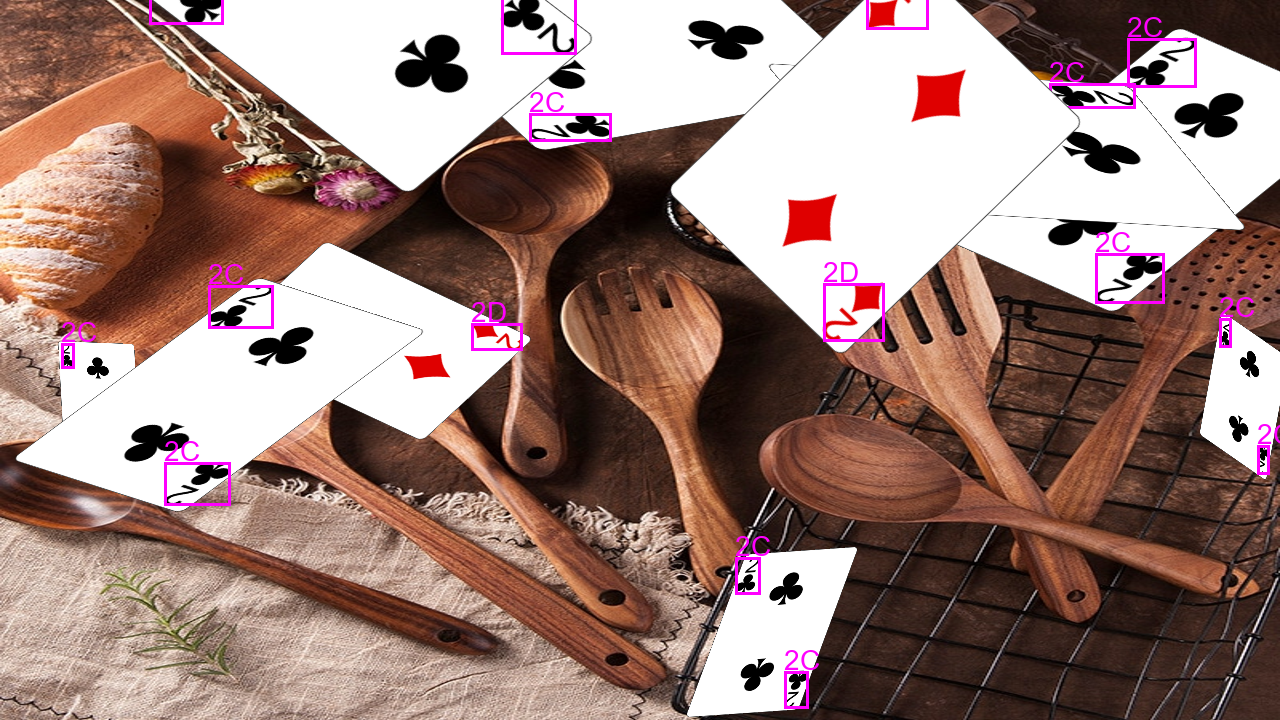

In [179]:
BACKGROUND_SIZE = (1280, 720)
CARD_SIZE = (250, 350)
CARDS_ROOT = "./YOLO_custom_dataset/images/"
POLYGONS_ROOT = "./YOLO_custom_dataset/labels/"

# загружаем изображение, которое выбрано в качестве фонового и изменяем его размер
background = Image.open(fp="./YOLO_custom_dataset/backgrounds/S98abe20eec4b4609974d012f9cd909cfc.png")
background = background.resize(size=BACKGROUND_SIZE, resample=Image.Resampling.BICUBIC)

cards = os.listdir("./YOLO_custom_dataset/images")
print("Всего изображений карт: %s" % len(cards))

for _ in range(10):
    # сэмплируем карту для вставки
    sample = np.random.choice(cards)
    card_loc = os.path.join(CARDS_ROOT, sample)
    card = Image.open(card_loc)
    card = card.resize(size=CARD_SIZE, resample=Image.Resampling.BICUBIC)

    # загружаем разметку
    f_name = os.path.splitext(sample)[0]
    f_ext = "txt"
    polygons_loc = os.path.join(POLYGONS_ROOT, f_name + os.extsep + f_ext)
    polygons = parse_polygons(loc=polygons_loc)
    
    # сэмлируем положение центра для карты из равномерного распределения
    x_center = np.random.uniform(low=0, high=BACKGROUND_SIZE[0])
    y_center = np.random.uniform(low=0, high=BACKGROUND_SIZE[1])
    print("Положение центра карты: %s, %s" % (x_center, y_center))

    # генерируем изображение карты
    card, masks = ra(card, polygons)
    w_card, h_card = card.size
    print("Размер сгенерированного изображения карты: %s, %s" % (w_card, h_card))
    x_card = int(x_center - w_card / 2)
    y_card = int(y_center - h_card / 2)

    # помещаем его на фоновую картинку
    background.paste(im=card, box=(x_card, y_card), mask=card)

    for cls_idx, mask in masks:
        cls_name = CLASSNAMES[cls_idx]
        left, right, bottom, top = mask2bbox(mask=mask)
        left, right = x_card + left, x_card + right
        bottom, top = y_card + bottom, y_card + top

        bbox = [(left, bottom), (right, top)]
        draw = ImageDraw.Draw(background, mode="RGBA")
        draw.rectangle(bbox, outline=(255, 0, 255, 255), width=3)

        font = ImageFont.truetype("arial.ttf", 28, encoding="unic")
        draw.text((left, bottom - 1), cls_name, font=font, fill=(255, 0, 255, 255), anchor="lb")
background